In [1]:
import pandas as pd
import numpy as np

from scipy.stats import spearmanr,ttest_ind
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.metrics import RocCurveDisplay,classification_report
from sklearn.model_selection import (train_test_split,cross_validate,
    GridSearchCV,StratifiedKFold)
from sklearn.feature_selection import RFECV,SelectFromModel
from sklearn.pipeline import Pipeline
import shap

from contextlib import redirect_stderr
import os
from tqdm.notebook import trange

In [2]:
%matplotlib inline
%load_ext watermark

In [3]:
# set a fixed random state for reproduceability random state from random.org
import random
random.seed(0x9e3047133e3412828a6be28778850f1d32b61c929e6859fae158ec6bce96c044b1bea5d0c60740f4800863a87a4f6775)
np.random.seed(random.randint(0, 0x1<<31))

collinear_gridsearch_rand_seed = random.getrandbits(30)
rfecv_rand_seed = random.getrandbits(30)
classification_report_rand_seed = random.getrandbits(30)
shap_bootstrap_rand_seed = random.getrandbits(30)

In [4]:
data = pd.read_csv('../data/grouped-cancer-dataset.csv.xz')
data.head()

,Hugo_Symbol,Label,LOC100130426,UBE2Q2P3,UBE2Q2P3.1,LOC149767,TIMM23,MOXD2,LOC155060,RNU12-2P,...,ZXDA,ZXDB,LOC100130182,ZYG11A,ZYG11B,ZYX,FLJ10821,ZZZ3,HUMRTVLH3,AKR1C6P
0,BA-A1-A0SO,E,0.0,12.5687,21.4958,383.9288,669.9357,0,143.0169,1.0814,...,71.6436,561.2536,374.1691,108.4117,1791.9022,1341.2231,821.0632,897.8436,444.4610,0.0
1,BA-A2-A04Q,E,0.0,1.1801,3.8334,185.5958,1706.1319,0,354.8014,0.3857,...,37.0228,298.4960,885.4609,127.2657,728.4998,4357.1153,896.6448,568.0679,26.2245,0.0
2,BA-A2-A04T,E,0.0,16.6878,23.9972,232.6558,758.0631,0,165.8698,0.3477,...,88.6725,739.2854,1018.8646,155.7854,1028.6012,3453.7077,1616.2740,655.1334,401.9821,0.0
3,BA-A2-A04U,E,0.0,0.0000,0.5195,411.4041,4388.1024,0,78.9713,0.0000,...,17.6646,174.0486,875.4384,130.4065,589.1674,3222.7562,617.7426,1264.0603,85.7254,0.0
4,BA-A2-A0D2,E,0.0,9.8281,9.3920,177.6492,1826.2798,0,164.8494,0.0000,...,41.0275,402.1438,906.6716,185.5480,1189.7986,10575.1247,743.6703,928.1094,20.3290,0.0


In [5]:
data.describe()

,LOC100130426,UBE2Q2P3,UBE2Q2P3.1,LOC149767,TIMM23,MOXD2,LOC155060,RNU12-2P,SSX9,LOC317712,...,ZXDA,ZXDB,LOC100130182,ZYG11A,ZYG11B,ZYX,FLJ10821,ZZZ3,HUMRTVLH3,AKR1C6P
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.0,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.006105,10.639727,10.021203,155.767873,1366.055649,0.0,205.331805,0.325925,0.315184,0.220193,...,52.125130,402.859620,1046.847814,155.232602,940.979580,5177.534854,1105.346948,1012.307186,226.644723,0.293591
std,0.048845,8.697243,7.858926,78.771835,679.889290,0.0,156.563507,0.414377,2.936522,1.629687,...,24.784909,168.060015,286.459651,126.529202,384.799084,2725.627891,450.914278,411.879425,281.428133,1.590348
min,0.000000,0.000000,0.000000,61.356500,345.121200,0.0,34.621600,0.000000,0.000000,0.000000,...,8.808000,86.318300,374.169100,0.587200,340.575500,1168.611800,351.851900,244.862000,1.787200,0.000000
25%,0.000000,4.183075,4.431550,102.349100,916.759375,0.0,107.842150,0.000000,0.000000,0.000000,...,32.582350,280.131575,849.554700,57.316650,686.346175,3435.013025,803.858975,682.617675,26.109600,0.000000
50%,0.000000,9.359550,7.962300,132.494250,1298.277450,0.0,164.682750,0.235550,0.000000,0.000000,...,51.245200,385.669450,1025.292150,128.699050,845.120700,4516.313950,1014.324900,976.320850,133.203000,0.000000
75%,0.000000,15.122225,12.955500,188.186600,1684.130925,0.0,236.366800,0.582800,0.000000,0.000000,...,65.832225,505.437450,1240.338275,231.031525,1112.490650,6459.738550,1335.991700,1259.015800,296.631650,0.000000
max,0.425400,53.997100,40.253600,505.282600,4850.556400,0.0,1042.919600,1.979700,32.811300,15.767600,...,135.308300,976.134100,1741.395300,590.197400,2449.850900,23934.233700,3300.239100,2839.058500,1467.178800,17.137400


In [6]:
print(data['Label'].value_counts())

X = data.drop(columns=['Hugo_Symbol', 'Label'])
Y = data['Label']

E    87
A    41
Name: Label, dtype: int64


In [7]:
min_data = pd.pivot_table(data, index=['Label'], aggfunc=np.min)
max_data = pd.pivot_table(data, index=['Label'], aggfunc=np.max)

np.any((min_data.loc['A'] > max_data.loc['E']) | (max_data.loc['A'] < min_data.loc['E']))


False

In [8]:
clf = Pipeline([
    ('standardize',StandardScaler()),
    ('clf', LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        verbose=True,
        max_iter=10000
    ))
])
selector = SelectFromModel(
    clf, 
    importance_getter='named_steps.clf.coef_'
)

selector.fit(X, Y)
l1_feature_names = selector.get_feature_names_out()

print('number of features', len(l1_feature_names))
print('Features selected:', *l1_feature_names)

[LibLinear].......................................*..........................................................*.......................................*................................................*...............................................................*............................*................*.****
optimization finished, #iter = 2929
Objective value = 3.370238
#nonzeros/#features = 96/20532
number of features 93
Features selected: ADAM19 FDH MRXE ATXN7L3 BET1L BRS3 DHRS4-AS1 C19ORF52 PRR34 C5ORF60 PLGRKT FIH CCDC51 CCL4L1 CREG2 CRHR1 CROCCP2 CRYAA CYP4V2 DDX51 DNASE1L1 ELMO3 DBIL5P ERCC3 FAM122C SAXO1 FAM19A4 MTFR1L FLJ26850 FOXA3 LD FOXQ1 GCM2 ADGRF2 GPR179 GPR17 GPR89B GUSBP3 HEXIM1 HIP1R IQCK KCNE3 KDM4C KIAA1324L KLK10 KRT40 KRTAP1-5 LGR6 TEKT4P2 LOC100133331 USP32P1 XRCC6P5 ASH1L-AS1 POLR1A LRFN4 LRRC37A2 MCPH1 DFNB30 A1BG-AS1 NRXN3 TENM2 OR52I1 OR7E5P PAX6 PDE8A PGLYRP1 PIF1 PKDREJ PLA2G4C POLR2J3 PPIL3 PRKY PRNT PRO0611 PRSS30P TESSP5 PWP2 KBF2 RETN RFPL4 RPS26P11

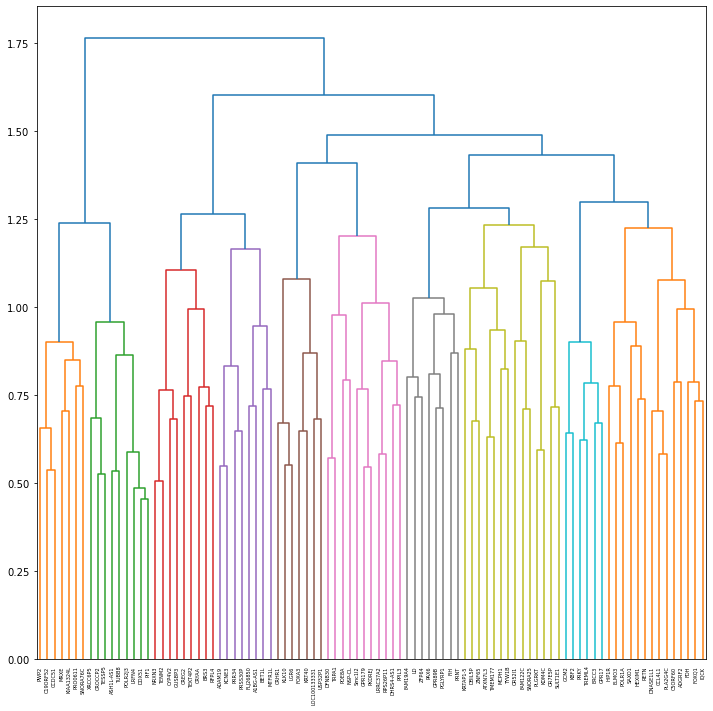

In [9]:
# borrowed directly from scikit learn docs:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features
corr = spearmanr(X[l1_feature_names]).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

plt.figure(figsize=(12,12))
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=l1_feature_names, ax=plt.gca(), leaf_rotation=90
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


selected theshold 0.6499999999999999
number of features selected 73
selected features: C19ORF52 PWP2 MRXE KIAA1324L PRO0611 SNORA76C CROCCP2 XRCC6P5 ASH1L-AS1 DDX51 NRXN3 CYP4V2 GUSBP3 CREG2 TEKT4P2 BRS3 RFPL4 CRYAA ADAM19 PRR34 FLJ26850 A1BG-AS1 BET1L MTFR1L KLK10 CRHR1 FOXA3 LOC100133331 USP32P1 DFNB30 PDE8A NSP-CL GPR179 Smc1l2 LRRC37A2 DHRS4-AS1 PPIL3 LD ZFP64 FAM19A4 GPR89B PGLYRP1 PAX6 FIH PRNT DBIL5P ZNF65 KRTAP1-5 ATXN7L3 MCPH1 TYW1B FAM122C SNORA25 OR52I1 PLGRKT OR7E5P SULT1E1 GCM2 PRKY ERCC3 GPR17 ELMO3 HIP1R HEXIM1 RETN SAXO1 CCL4L1 DNASE1L1 C5ORF60 ADGRF2 FOXQ1 IQCK FDH


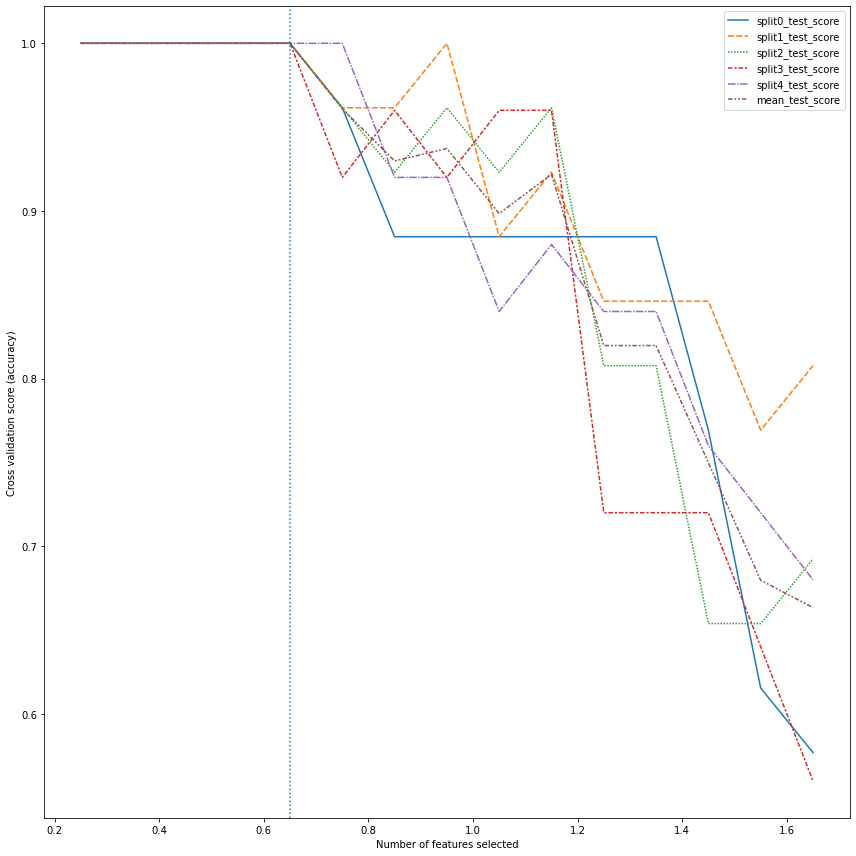

In [10]:
def drop_collinear_features(X, threshold=0):
    # borrowed directly from scikit learn docs:
    # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features
    corr = spearmanr(X[l1_feature_names]).correlation
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    clustering = hierarchy.fcluster(dist_linkage, t=threshold, criterion='distance')
    return X.iloc[:,np.unique(clustering, return_index=True)[1]]

test_clf = Pipeline([
    ('drop_features', FunctionTransformer(drop_collinear_features)),
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'
    ))
])

thresholds = list(np.arange(0.25,1.75,0.1))[::-1]
search = GridSearchCV(
    test_clf,
    { 'drop_features__kw_args' : [
        { 'threshold' : v }
            for v in thresholds
    ]},
    cv=StratifiedKFold(
        random_state=collinear_gridsearch_rand_seed,
        shuffle=True
    )
)
with np.errstate(divide='ignore', invalid='ignore'):
    search.fit(X[l1_feature_names], Y)

selected_threshold = search.best_params_['drop_features__kw_args']['threshold']
print('selected theshold', selected_threshold)
ward_feature_names = drop_collinear_features(X[l1_feature_names], selected_threshold).columns
print('number of features selected', len(ward_feature_names))
print('selected features:', *ward_feature_names)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(12,12))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
selector_data = pd.DataFrame.from_dict(search.cv_results_)
selector_data.drop(
    columns=[
        'mean_fit_time',
        'std_fit_time',
        'mean_score_time',
        'std_score_time',
        'std_test_score',
        'rank_test_score'
    ],
    inplace=True
)
selector_data.set_index(iter(thresholds), inplace=True)

sns.lineplot(
    data=selector_data
)
plt.axvline(
    search.best_params_['drop_features__kw_args']['threshold'],
    linestyle=':',
    label='threshold chosen'
)
plt.tight_layout()
plt.savefig('../figures/gridsearchcv-line-plot.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Optimal number of features : 43
Features selected: C19ORF52 PWP2 KIAA1324L SNORA76C CROCCP2 XRCC6P5 ASH1L-AS1 DDX51 CYP4V2 GUSBP3 CREG2 BRS3 CRYAA FLJ26850 KLK10 CRHR1 FOXA3 USP32P1 NSP-CL LRRC37A2 DHRS4-AS1 PPIL3 ZFP64 PGLYRP1 FIH PRNT ZNF65 TYW1B FAM122C SULT1E1 PRKY GPR17 ELMO3 HIP1R HEXIM1 RETN SAXO1 CCL4L1 DNASE1L1 ADGRF2 FOXQ1 IQCK FDH


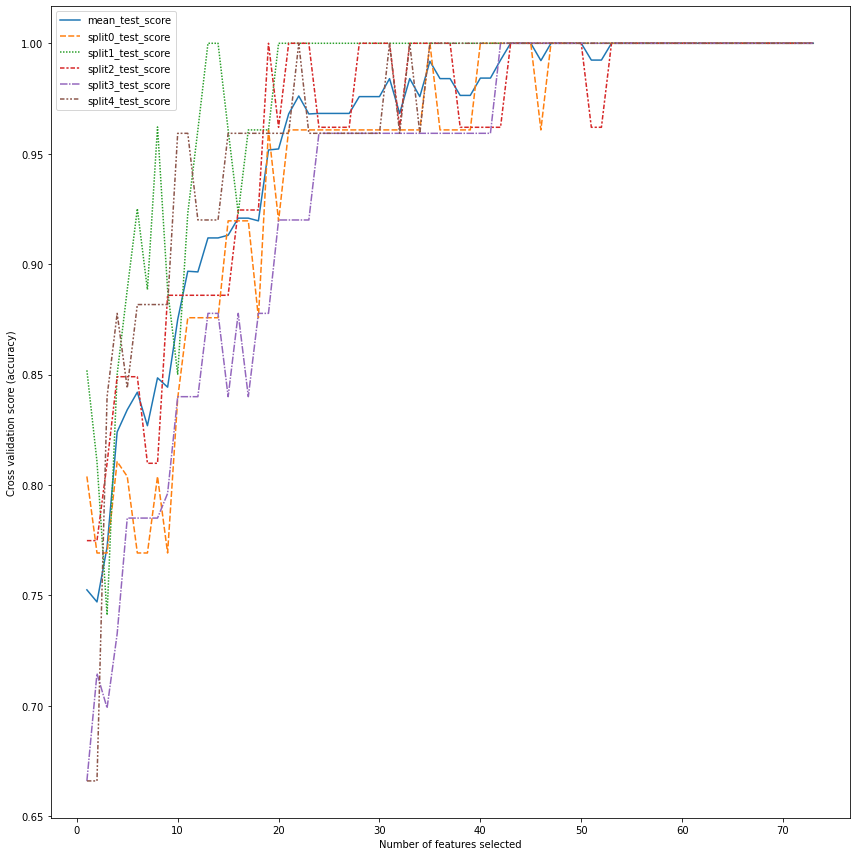

In [11]:
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'
    ))
])
selector = RFECV(
    test_clf,
    scoring='f1_weighted',
    importance_getter='named_steps.svc.coef_',
    cv=StratifiedKFold(random_state=rfecv_rand_seed, shuffle=True)
)
selector.fit(X[ward_feature_names], Y)
rfecv_feature_names = selector.get_feature_names_out()

print("Optimal number of features : %d" % selector.n_features_)
print('Features selected:', *rfecv_feature_names)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(12,12))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
selector_data = pd.DataFrame.from_dict(selector.cv_results_)
selector_data.set_index(np.arange(1,selector.n_features_in_+1), inplace=True)
selector_data.drop(columns='std_test_score', inplace=True)

sns.lineplot(
    data=selector_data
)
plt.tight_layout()
plt.savefig('../figures/RFECV-line-plot.eps')
plt.show()

In [12]:
feature_X_train, feature_X_test, y_train, y_test = train_test_split(
    data[rfecv_feature_names],
    Y,
    stratify=Y,
    random_state=classification_report_rand_seed
)
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear',
        probability=True))
])
test_clf.fit(feature_X_train, y_train)
print(classification_report(
    y_test,
    test_clf.predict(feature_X_test)
))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        10
           E       1.00      1.00      1.00        22

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [13]:
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear',
        probability=True))
])
cross_validate(
    test_clf,
    data[rfecv_feature_names],
    Y,
    scoring=[
        'balanced_accuracy',
        'roc_auc',
        'f1_weighted'
    ]
)

{'fit_time': array([0.00488949, 0.00407219, 0.00394583, 0.00386763, 0.00416231]),
 'score_time': array([0.00417137, 0.00418401, 0.00390935, 0.00435758, 0.00376773]),
 'test_balanced_accuracy': array([1., 1., 1., 1., 1.]),
 'test_roc_auc': array([1., 1., 1., 1., 1.]),
 'test_f1_weighted': array([1., 1., 1., 1., 1.])}

In [14]:
rand_state = np.random.RandomState(seed=shap_bootstrap_rand_seed)
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear',
        probability=True,
        random_state=rand_state
    ))
])

replicates = []
for _ in trange(500, leave=False):
    feature_X_train, feature_X_test, y_train, y_test = train_test_split(
        X[rfecv_feature_names],
        Y,
        stratify=Y,
        random_state=rand_state
    )

    test_clf.fit(feature_X_train.values, y_train.values)
    with redirect_stderr(open(os.devnull, 'w')):
        explainer = shap.KernelExplainer(
            test_clf.predict_proba,
            feature_X_train
        )
        shap_values = explainer.shap_values(
            feature_X_test,
            link='logit',
            silent=True)
    replicates.append(np.abs(shap_values[1]).mean(axis=0))

  0%|          | 0/500 [00:00<?, ?it/s]

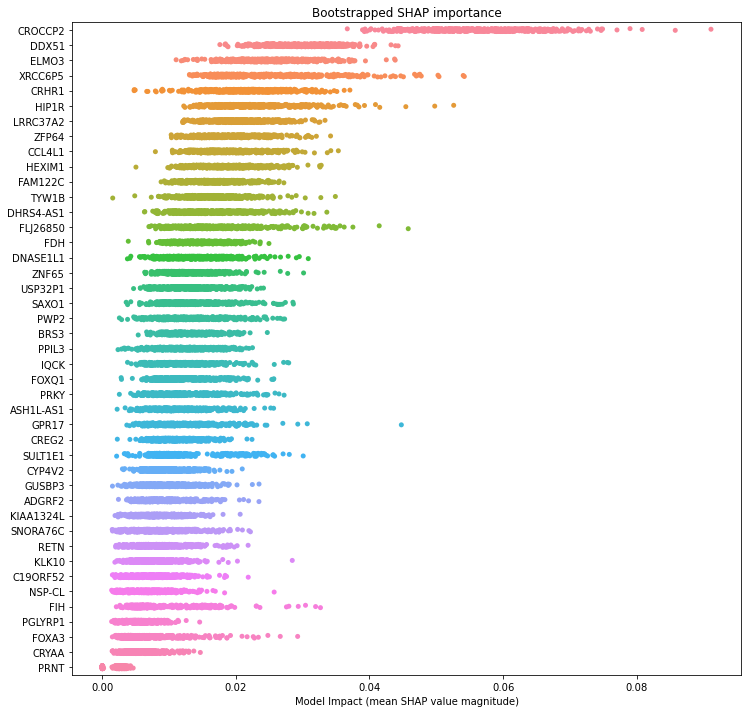

In [15]:
shap_data = pd.DataFrame(
  np.row_stack(replicates),
  columns=rfecv_feature_names
)

plt.figure(figsize=(12,12))
plt.title('Bootstrapped SHAP importance')
plt.xlabel('Model Impact (mean SHAP value magnitude)')
sns.stripplot(
    data=shap_data,
    orient='h',
    order=list(shap_data.median(axis=0).sort_values(ascending=False).index)
)
plt.savefig('../figures/bootstrap-shap-importance.eps')
plt.show()

In [16]:
def fdr(p_vals): # Benjamini-Hochberg
    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'))
])
test_clf.fit(X[rfecv_feature_names], Y)

pval_col_name = 'FDR'
df = pd.DataFrame(
    {
        test_clf.classes_[1]+'A' : [ 'H' if coef > 0 else 'L' for coef in test_clf.named_steps.svc.coef_[0]],
        test_clf.classes_[0]+'A' : [ 'H' if coef < 0 else 'L' for coef in test_clf.named_steps.svc.coef_[0]],
        'EA means' : X[Y == 'E'][rfecv_feature_names].mean().round(2),
        'AA means' : X[Y == 'A'][rfecv_feature_names].mean().round(2),
         pval_col_name : fdr(ttest_ind(
            X[Y == 'E'][rfecv_feature_names],
            X[Y == 'A'][rfecv_feature_names],
            axis=0
        )[1]).round(3)
    },
    index=rfecv_feature_names
)
df.sort_values(pval_col_name, inplace=True)
ttest_feature_names = df[df[pval_col_name] < 0.05].index
df.replace(0, value='< 0.001', inplace=True)
df

,EA,AA,EA means,AA means,FDR
C19ORF52,L,H,299.76,396.82,< 0.001
CCL4L1,L,H,88.93,178.35,< 0.001
RETN,L,H,1.24,9.86,< 0.001
HIP1R,L,H,932.62,1620.51,< 0.001
ELMO3,L,H,381.44,679.34,< 0.001
PRKY,L,H,2.26,5.93,< 0.001
ZFP64,L,H,485.34,607.47,< 0.001
DHRS4-AS1,H,L,649.67,388.31,< 0.001
LRRC37A2,H,L,125.21,61.89,< 0.001
CRHR1,L,H,72.0,286.06,< 0.001


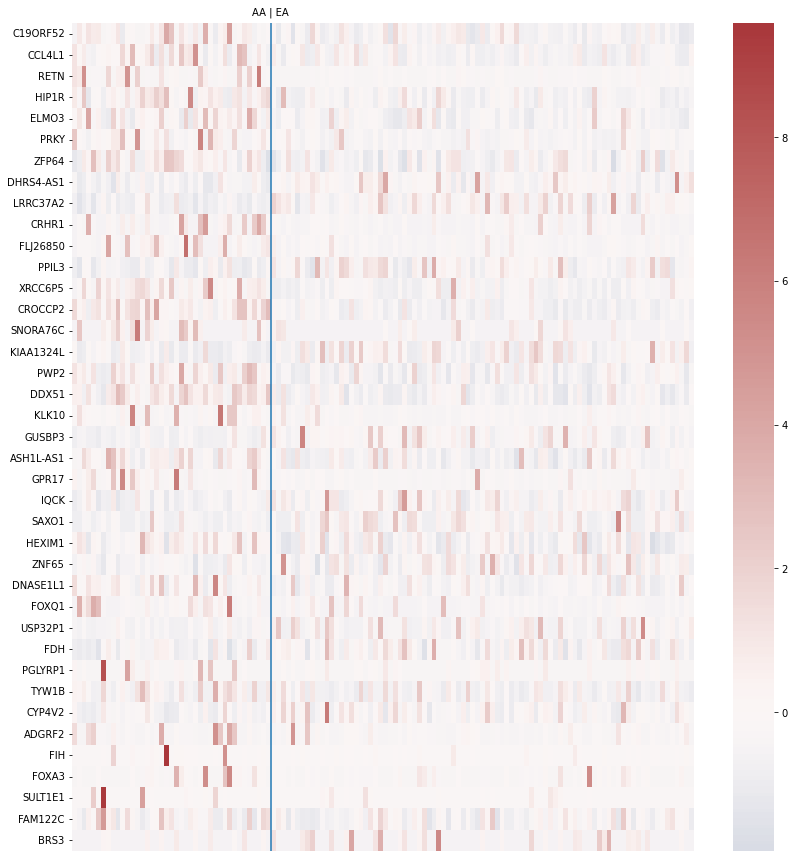

In [17]:
scaler = StandardScaler()
idx_order = np.argsort(Y)
plt.figure(figsize=(12,12))
sns.heatmap(
    data=scaler.fit_transform(data[ttest_feature_names].iloc[idx_order,:]).T,
    center=0,
    xticklabels=False,
    yticklabels=ttest_feature_names,
    cmap='vlag'
)
vline_pos = list(Y.iloc[idx_order]).index('E')
plt.axvline(vline_pos)
plt.text(vline_pos-4, -0.4, 'AA | EA')

plt.savefig('../figures/expression-heatmap.eps')
plt.tight_layout()

In [18]:
%watermark \
--python \
--packages pandas,sklearn,scipy,matplotlib,seaborn,shap \
--date --updated

Last updated: 2022-03-09

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 7.31.1

pandas    : 1.3.5
sklearn   : 1.0.2
scipy     : 1.7.3
matplotlib: 3.5.0
seaborn   : 0.11.2
shap      : 0.40.0

